## Download and prepare the CIFAR10 dataset

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

### Blog
https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb

In [1]:
from tensorflow.keras import datasets
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [2]:
class_names = ['0.airplane', '1.automobile', '2.bird', '3.cat', '4.deer',
               '5.dog', '6.frog', '7.horse', '8.ship', '9.truck']
display(class_names)

['0.airplane',
 '1.automobile',
 '2.bird',
 '3.cat',
 '4.deer',
 '5.dog',
 '6.frog',
 '7.horse',
 '8.ship',
 '9.truck']

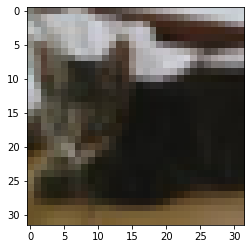

Actual Label : [3]


In [3]:
import matplotlib.pyplot as plt

pict = 9
# Visualizing Data¶
pic  = train_images[pict]
plt.imshow(pic,cmap = plt.cm.binary)
plt.show()

# Actual Label
print("Actual Label :",train_labels[pict])

Or let's plot the first 25 images from the training set and display the class name below each image.

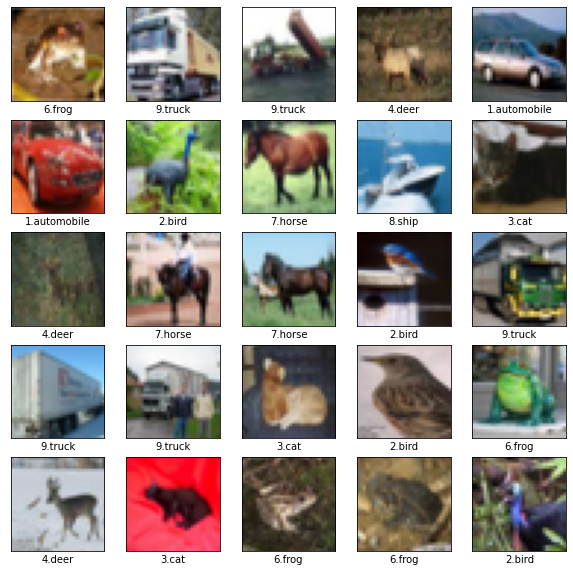

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = train_images / 255.0, test_images / 255.0

# One hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels) 
y_test = to_categorical(test_labels)

In [6]:
# model input shape
from tensorflow.keras import Input

input_shape = train_images[0,:,:,:].shape
model_input = Input(shape=input_shape)
print(model_input.shape)

(None, 32, 32, 3)


# Creating a callback function to minimize further code

In [7]:
# saving model, creating log for tensorboaed and applying few callbacks

def callbacks(Log,Dir):
  import tensorflow as tf
  import os

  Filepath = Path
  logdir = os.path.join(Filepath, Dir)
  
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                 #  tensorboard log path      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # stop if not improving
                    monitor='val_accuracy',patience=2,),           # monitor validation accuracy
                    #tf.keras.callbacks.ReduceLROnPlateau(
                    #monitor='val_loss',factor=0.1,         # lr ko .1 se multiply kerdo (kam kerdo)
                    #patience=10,),                # reduce the lrate if val loss stop improving
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # save model path
                    monitor='val_loss',             # only save best weights
                    save_best_only=True,)]
  return callbacks_list

### 1st model

In [8]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Model, optimizers

#model_input = Input(shape=(32, 32, 3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = Flatten()(x)
output = Dense(10, activation='softmax')(x) 

model1 = Model(inputs=model_input, outputs=output)
#model1.summary()

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
#opt = optimizers.Adam(lr=1e-3)
opt = "Adam"
model1.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [9]:
Path = "model1"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

history = model1.fit(x_train, y_train,
                     batch_size=32, epochs = 20,
                     validation_split = 0.2,
                     callbacks=Call_B_Fun)

Epoch 1/20
   1/1250 [..............................] - ETA: 0s - loss: 2.3003 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1249/1250 [============================>.] - ETA: 0s - loss: 1.4136 - accuracy: 0.4940WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1/assets
1250/1250 [=======

### To view in Tensorboard

In [10]:
#%load_ext tensorboard
#%tensorboard --logdir=model1/my_log_dir

## Evaluate the model by calculating the error rate on the test set.

In [11]:
import numpy as np

def evaluate_error(model):
  pred = model.predict(x_test, batch_size = 32)
  pred = np.argmax(pred, axis=1)
  pred = np.expand_dims(pred, axis=1) # make same shape as y_test
  error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]   
  return error

evaluate_error(model1)

8.9368

### 2nd model

In [12]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model, optimizers

#model_input = Input(shape=(32, 32, 3))

#mlpconv block1
x = Conv2D(32, (5, 5), activation='relu',padding='valid')(model_input)
x = Conv2D(32, (1, 1), activation='relu')(x)
x = Conv2D(32, (1, 1), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.5)(x)

#mlpconv block2
x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
x = Conv2D(64, (1, 1), activation='relu')(x)
x = Conv2D(64, (1, 1), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.5)(x)

#mlpconv block3
x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
x = Conv2D(32, (1, 1), activation='relu')(x)
x = Conv2D(10, (1, 1), activation='relu')(x)
x = GlobalAveragePooling2D()(x)

x = Flatten()(x)
output = Dense(10, activation='softmax')(x) # sigmoid

model2 = Model(inputs=model_input, outputs=output)
#model1.summary()

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
#opt = optimizers.Adam(lr=1e-3)
opt = "Adam"
model2.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [13]:
Path = "model2"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

history = model2.fit(x_train, y_train,
                     batch_size=32, epochs = 20,
                     validation_split = 0.2,
                     callbacks=Call_B_Fun)

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9571 - accuracy: 0.2535 - val_loss: 1.7029 - val_accuracy: 0.3492
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.6334 - accuracy: 0.3937 - val_loss: 1.5446 - val_accuracy: 0.4295
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4984 - accuracy: 0.4492 - val_loss: 1.4092 - val_accuracy: 0.4812
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4177 - accuracy: 0.4805 - val_loss: 1.3904 - val_accuracy: 0.4979
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3575 - accuracy: 0.5050 - val_loss: 1.2667 - val_accuracy: 0.5449
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3104 - accuracy: 0.5288 - val_loss: 1.2302 - val_accuracy: 0.5604
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.2678 - accuracy: 0.5446 - val_loss: 1.2098 - val_accuracy:

In [14]:
evaluate_error(model2)

8.6473

In [15]:
# to view in Tensorboard

#%load_ext tensorboard
#%tensorboard --logdir=model2/my_log_dir

### 3rd model (lets use a pretrained model)


In [16]:
from tensorflow.keras import Input
input_tensor = Input(shape=(32, 32, 3))

from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,
                  input_tensor = input_tensor)

#conv_base.summary()
from tensorflow.keras import layers, optimizers, Input, Model

input_tensor = Input(shape=(32, 32, 3))
x = conv_base(input_tensor)
y = layers.Flatten()(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(10, activation='softmax')(z)

model3 = Model(input_tensor, output_tensor)

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
#opt = optimizers.Adam(lr=1e-3)
opt = "Adam"
model3.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

#model.summary()

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
Path = "model3"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

history = model3.fit(x_train, y_train,
                     batch_size=32, epochs = 20,
                     validation_split = 0.2,
                     callbacks=Call_B_Fun)

Epoch 1/20
1250/1250 [==============================] - 28s 22ms/step - loss: 2.0175 - accuracy: 0.1888 - val_loss: 1.8068 - val_accuracy: 0.2488
Epoch 2/20
1250/1250 [==============================] - 28s 22ms/step - loss: 1.7257 - accuracy: 0.2956 - val_loss: 1.6008 - val_accuracy: 0.3762
Epoch 3/20
1250/1250 [==============================] - 28s 22ms/step - loss: 1.4616 - accuracy: 0.4258 - val_loss: 1.3591 - val_accuracy: 0.4582
Epoch 4/20
1250/1250 [==============================] - 27s 22ms/step - loss: 1.2312 - accuracy: 0.5465 - val_loss: 1.1678 - val_accuracy: 0.5729
Epoch 5/20
1250/1250 [==============================] - 27s 22ms/step - loss: 1.0637 - accuracy: 0.6209 - val_loss: 1.0703 - val_accuracy: 0.6173
Epoch 6/20
1250/1250 [==============================] - 28s 22ms/step - loss: 0.9323 - accuracy: 0.6753 - val_loss: 0.9295 - val_accuracy: 0.6827
Epoch 7/20
1250/1250 [==============================] - 25s 20ms/step - loss: 0.8314 - accuracy: 0.7118 - val_loss: 0.9617 -

In [18]:
evaluate_error(model3)

8.9328

In [19]:
# to view in Tensorboard

#%load_ext tensorboard
#%tensorboard --logdir=model3/my_log_dir

### Evaluation codes

In [20]:
#evaluation = model1.evaluate(x_test,y_test,verbose=2)
#print()
#print("Loss: ",evaluation[0]*100,"%")
#print("Accuracy: ",evaluation[1]*100,"%")

### Prediction codes

Predicted value:  6
Actual value:  6


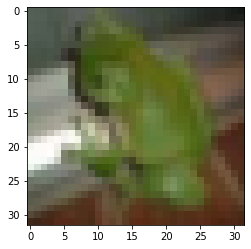

['0.airplane',
 '1.automobile',
 '2.bird',
 '3.cat',
 '4.deer',
 '5.dog',
 '6.frog',
 '7.horse',
 '8.ship',
 '9.truck']

In [21]:
predict = 7
#a = model1.predict_classes(x_test)[predict] # works on sequential Api
a = np.argmax(model1.predict(x_test)[predict]) # works on Functional Api
print("Predicted value: ",a)
print("Actual value: ",np.argmax(y_test[predict]))
pic  = x_test[predict]
plt.imshow(pic,cmap = plt.cm.binary)
plt.show()
display(class_names)

In [22]:
# lets print all three models error
E1 = evaluate_error(model1)
E2 = evaluate_error(model2)
E3 = evaluate_error(model3)

print("Model 1 :",E2)
print("Model 2 :",E2)
print("Model 3 :",E3)

Model 1 : 8.6473
Model 2 : 8.6473
Model 3 : 8.9328


In [23]:
# Lets evaluate all three models

evaluation1 = model1.evaluate(x_test,y_test,verbose=2)
print("Model1 :")
print("Loss: ",evaluation1[0]*100,"%")
print("Accuracy: ",evaluation1[1]*100,"%")
print("Model2 :")
evaluation2 = model2.evaluate(x_test,y_test,verbose=2)
print()
print("Loss: ",evaluation2[0]*100,"%")
print("Accuracy: ",evaluation2[1]*100,"%")
print("Model3 :")
evaluation3 = model3.evaluate(x_test,y_test,verbose=2)
print()
print("Loss: ",evaluation3[0]*100,"%")
print("Accuracy: ",evaluation3[1]*100,"%")

313/313 - 1s - loss: 0.9489 - accuracy: 0.6975
Model1 :
Loss:  94.8875904083252 %
Accuracy:  69.74999904632568 %
Model2 :
313/313 - 1s - loss: 0.9956 - accuracy: 0.6515

Loss:  99.56130981445312 %
Accuracy:  65.14999866485596 %
Model3 :
313/313 - 2s - loss: 0.9103 - accuracy: 0.7014

Loss:  91.03076457977295 %
Accuracy:  70.13999819755554 %


### Merging all three models prediction (our main target)
The easiest way to pool the predictions of a set
of classifiers (to ensemble the classifiers) is to average their predictions at inference time.

#
0.33 defines the amount of data we take from each models (not sure)

In [24]:
preds_a = model1.predict(x_test)
preds_b = model2.predict(x_test)
preds_c = model3.predict(x_test)

final_preds = 0.33 * (preds_a + preds_b + preds_c)

### Predicting from the Merged prediction

In [25]:
predict = 7
a = np.argmax(final_preds[predict])
print("Predicted value: ",a)
print("Actual value: ",np.argmax(y_test[predict]))

Predicted value:  6
Actual value:  6



A smarter way to ensemble classifiers is to do a weighted average, where the
weights are learned on the validation data—typically, the better classifiers are given a
higher weight, and the worse classifiers are given a lower weight. To search for a good
set of ensembling weights, you can use random search or a simple optimization algorithm such as Nelder-Mead:

In [26]:
preds_a = model1.predict(x_test)
preds_b = model2.predict(x_test)
preds_c = model3.predict(x_test)

final_preds2 = 0.30 * preds_a + 0.60 * preds_b + 0.1 * preds_c

predict = 7
a = np.argmax(final_preds[predict])
print("Predicted value: ",a)
print("Actual value: ",np.argmax(y_test[predict]))

Predicted value:  6
Actual value:  6
